## Apply a function to every gridpoint

This tutorial demonstrates best practice to vectorise functions that want to be applied across all grid points.

When you need to compute something separately at many gridpoints, especially if it is fast at a single gridpoint, putting this computation into a for loop can be very slow. Instead, it is prefereable to vectorise a function, so that the numpy and/or dask backend can distribute the work across multiple cores.

That is, to find the mean at each location, with an xarray dataset with dimensions `lon`, `lat`, and `time` instead of

```python
out = np.zeros(N, M)
for i in range(N):
    for j in range(M):
        out[i, j] = data.isel(lon=i, lat=j).mean()
```
we write:

```python
out = data.mean(dim=('time'))
```
which xarray inteprets as to take the mean in the time dimension for every gridpoint.

Some functions, such as ```scipy.stats.linregress```, do not have in-build vectorisation, but you might want to apply a function like this to every gridpoint, and for loops would be slow. 

This tutorial **provides a few examples of how to apply functions which do not natively vectorise many times to an xarray dataset, vectorised so that a dask client can speed up the calculation**. We answer here a dummy question "What is sea-surface temperature trend at each gridpoint of an ocean model, and is it significant?". Scientifically, this question mostly applies to the forcing dataset and not the ocean model, but it's as good an example as any.

To achieve this goal, we use ```xarray.apply_ufunc```, which is very versatile, but therefore takes many arguments that can be difficult to interpret at first glance. The aim of the example below is to give something that will work on a problem similar to what COSIMA users may encounter.

For full documentation of ```xarray.apply_ufunc``` refer to: https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats
import cartopy.crs as ccrs
import intake
catalog = intake.cat.access_nri

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1, memory_limit=0)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33961,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45051,Total threads: 1
Dashboard: /proxy/36751/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42849,


Get some data

In [3]:
experiment = '025deg_jra55_iaf_omip2_cycle6'
sst = catalog[experiment].search(frequency="1mon", variable="sst").to_dask(
    xarray_open_kwargs={'chunks':{'time':-1}}
)
sst

<xarray.Dataset> Size: 5GB
Dimensions:   (time: 732, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Data variables:
    sst       (time, yt_ocean, xt_ocean) float32 5GB dask.array<chunksize=(12, 216, 240), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_month.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['sst']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          dbar,Pa,(kg/m^3)*m,m,meter,m^2,...
    intake_esm_attrs:filename:                ocean_month.nc
    intake_esm_attrs:file_id:                 ocean_month
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month.1mon

Rechunk so that there is only one chunk in the time dimension that will be used the linear regression.

In [4]:
sst = sst.chunk({'time': -1})
sst

<xarray.Dataset> Size: 5GB
Dimensions:   (time: 732, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Data variables:
    sst       (time, yt_ocean, xt_ocean) float32 5GB dask.array<chunksize=(732, 216, 240), meta=np.ndarray>
Attributes: (12/16)
    filename:                                 ocean_month.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['sst']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          dbar,Pa,(kg/m^3)*m,m,meter,m^2,...
    intake_esm_attrs:filename:                ocean_month.nc
    intake_esm_attrs:file_id:                 ocean_month
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month.1mon

Define a function that takes the data we have and returns what we want.

In [5]:
def get_trend(time, timeseries):
    '''Calculate the trend through a timeseries using scipy.stats.linregress, 
    and return just the slope and the p value as an array, for the purposes of 
    demonstrating xarray.apply_ufunc

    Inputs:
        time: np.ndarray
            the times or x values of whatever the slope will go through
        timeseries: np.ndarray
            the data to calculate the slope of

    Outputs:
        stats: np.ndarray
            1st element is the trend in timeseries
            2nd element is the p value of this trend, indicating the significance
            They're lumped together into one variable, a) so .load() can be called 
            on both at once, and b) to demonstrate some of the nuance in xr.apply_ufunc
            when using it for more complicated applications
    '''

    slope, intercept, r, p, se = scipy.stats.linregress(time, timeseries)
    return np.array((slope, p)) # Combine into one array because it's easier to load in one go

Define a timeseries for the linear regression to work (because scipy doesn't like datetimes).


**Note**: This line is specific to the function being applied - in this instance, we want to apply `scipy.stats.linregress`, and it needs a timeseries of x values so we make it one.

In [6]:
years_since_start = xr.DataArray(np.arange(sst.time.shape[0])/12,
                                 dims=('time',),
                                 coords={'time': sst.time})

# Pass data through to the `xarray.apply_ufunc`
stats = xr.apply_ufunc(get_trend,                               # function being used
                       years_since_start,                       # Argument 1 for function
                       sst["sst"],                              # Argument 2 for function
                       input_core_dims=(('time',), ('time',)),  # Dimensions the function needs for each argument
                       output_core_dims=(('stat_type',),),      # Dimensions of each output from the function
                       dask_gufunc_kwargs = {
                        "output_sizes": {'stat_type': 2},       # The new dimension will have size 2
                       },
                       vectorize=True,                          # The function needs to only have one lat and lon at a time
                       dask = 'parallelized',                   # Dask is fine, but the function can't handle it so apply_ufunc needs to
                       )
stats

<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440, stat_type: 2)> Size: 25MB
dask.array<transpose, shape=(1080, 1440, 2), dtype=float64, chunksize=(216, 240, 2), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
Dimensions without coordinates: stat_type

This last function call is roughly equivalent to

```python
stats = np.zeros(2, len(sst.xt_ocean), len(sst.yt_ocean))

for i in range(len(sst.xt_ocean)):
    for j in range(len(sst.yt_ocean)):
        slope,intercept = get_trend(years_since_start, sst.isel(xt_ocean=i, yt_ocean=j)
        stats[0, i, j] = slope
        stats[1, i, j] = intercept
```
But the loading step (next cell) should be faster than this computation in a for loop

In [7]:
%%time 
stats.load()

# Put data back into some more useful variable names
sst_trend = stats.sel(stat_type=0)
p_value = stats.sel(stat_type=1)

sst_trend

CPU times: user 25.1 s, sys: 3.31 s, total: 28.4 s
Wall time: 2min 56s


<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440)> Size: 12MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

Plot the calculated slope, stippling all regions that are significant at $p<0.05$. Before we plot we need to load the unmasked coordinates of geographic latitude and longitude and attach them to the dataset. If we don't use these cooridings the regions near the poles are distorted (see the [Making_Maps_with_Cartopy](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Making_Maps_with_Cartopy.html#Fixing-the-tripole) tutorial).

In [8]:
geolon_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolon_t
geolat_t = xr.open_dataset("/g/data/ik11/grids/ocean_grid_025.nc").geolat_t

sst_trend = sst_trend.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})
p_value = p_value.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

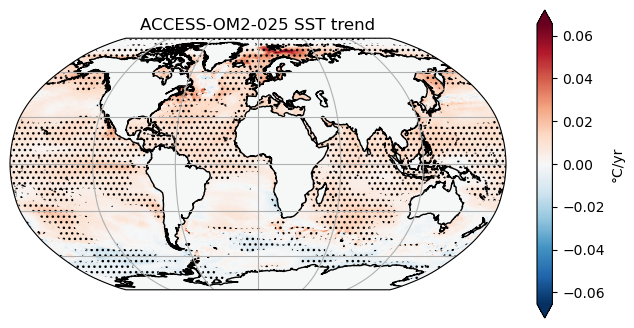

In [9]:
fig = plt.figure(figsize=(8, 4))

ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines(resolution="50m")
ax.gridlines(draw_labels=False)

sst_trend.plot(ax=ax,
               x="geolon_t",
               y="geolat_t",
               transform=ccrs.PlateCarree(),
               cbar_kwargs={'label': '°C/yr',
                            'extend': 'both'})

plt.contourf(p_value.geolon_t, p_value.geolat_t, p_value,
             levels=(0, 0.05),
             colors='None',
             hatches=('...',),
             transform=ccrs.PlateCarree())

plt.title('ACCESS-OM2-025 SST trend');

In [10]:
client.close()